**Physical Properties**

In [1]:
import pandas as pd
import numpy as np
from thermo import ChemicalConstantsPackage, PRMIX, CEOSLiquid, CEOSGas, FlashPureVLS,IAPWS95Gas,IAPWS95Liquid
from thermo.interaction_parameters import IPDB
import matplotlib.pyplot as plt

In [2]:
def get_flasher_object(T,P,components_dict,water_only = False):
    """
    Obtain a flasher object for performing flash calculations on a mixture of gases or liquids.

    Parameters:
    T (float): Temperature in degrees Celsius (converted to Kelvin internally, T + 273.15).
    P (float): Pressure in bar (converted to Pascal internally, P * 1E5).
    components_dict (dict): Dictionary containing the components of the mixture where keys are component names
                            and values are their respective mole fractions.
    water_only (bool, optional): Flag indicating whether to use only water properties for the flash calculation.
                                 Defaults to False.

    Returns:
    FlashObject: Object containing results of the flash calculation, including phase compositions,
                 phase amounts, and other relevant thermodynamic properties.

    Notes:
    - For multi-component mixtures (when water_only is False), uses the Peng-Robinson equation of state
      (PRMIX) for both liquid and gas phases.
    - When water_only is True, uses the IAPWS-95 formulation specific to water properties for flash calculation.

    """
    T = T +273.15 # Convert C to K
    P = P*1E5 #Convert Bar to Pa
    # These are possible components you could use, there's a lot more and you may want to check THERMO library Documentation
    # gases_list = ['water', 'hydrogen', 'nitrogen', 'carbon dioxide', 'hydrogen sulfide','methane',
    # 'ethane', 'propane', 'isobutane', 'n-butane', 'isopentane', 'n-pentane', 'hexane',
    # 'heptane', 'octane', 'nonane']
    #liquid_list= ['water', 'ethanol', 'methanol', 'acetic acid', 'propylene glycol', 'glycerol', 'dimethyl sulfoxide', 'benzene', 'toluene', 'xylene', 'acetone', 'butanol', 'pentanol', 'hexanol', 'heptanol', 'octanol', 'nonanol', 'decanol', 'ethylene glycol', 'diethylene glycol', 'propylene carbonate', 'tetrahydrofuran', 'acetonitrile', 'formamide', 'isopropyl alcohol', 'methyl ethyl ketone', 'dioxane', 'pyridine', 'hexamethylphosphoramide','dimethylamine', 'diethylamine', 'triethylamine', 'trimethylamine', 'ethanolamine', 'diethanolamine', 'triethanolamine', 'methyldiethanolamine', 'piperazine']
    components_list = list(components_dict.keys())
    constants, correlations = ChemicalConstantsPackage.from_IDs(components_list)
    zs = list(components_dict.values())
    eos_kwargs = dict(Tcs=constants.Tcs, Pcs=constants.Pcs, omegas=constants.omegas)
    if water_only == False:
        liquid = CEOSLiquid(PRMIX, HeatCapacityGases=correlations.HeatCapacityGases,
        eos_kwargs=eos_kwargs)
        gas = CEOSGas(PRMIX, HeatCapacityGases=correlations.HeatCapacityGases,
        eos_kwargs=eos_kwargs)
    if water_only:
        gas = IAPWS95Gas(T=T, P=P, zs=zs)
        liquid = IAPWS95Liquid(T=T, P=P, zs=zs)
    #flasher = FlashVL(constants, correlations, liquid=liquid, gas=gas)
    flasher = FlashPureVLS(constants, correlations, liquids=[liquid], gas=gas, solids=[])
    
    flash_object = flasher.flash(P=P, T=T,zs=zs)
    return flash_object
T,P = 25, 1 # Celcuis and bar
components_dict = {'methane':0.5,
    'ethane':0.25, 'propane':0.125, 'isobutane':0.0625, 'n-butane':0.0625}
flash_object  = get_flasher_object(T,P,components_dict)
molecular_weight = flash_object.MW()
density = flash_object.rho_mass() # kg/m3
viscosity = flash_object.mu()*1000 # Convert from Pa.s to cP
Cp = flash_object.Cp_mass()/1000 # kJ/kg
Cp_over_Cv = Cp/(flash_object.Cv_mass()/1000)

In [3]:
def results_df(results_dict,calculations):
    index_dict = {i:j for i,j in enumerate(calculations)}
    results_df_ = pd.DataFrame.from_dict(results_dict).rename(index=index_dict)
    return results_df_
results_dict = {'Molecular_Weight':[molecular_weight,28.32],'Density':[density,1.150],'Viscosity':[viscosity,1.018E-2],'Cp':[Cp,1.872],'Cp/Cv':[Cp_over_Cv,1.192]}
results_df(results_dict,['Thermo Library - PR','Commercial Software - HYSYS'])

,Molecular_Weight,Density,Viscosity,Cp,Cp/Cv
Thermo Library - PR,28.315718,1.150183,0.009709,1.856969,1.193719
Commercial Software - HYSYS,28.320000,1.150000,0.010180,1.872000,1.192000


In [4]:
T,P = 25, 1 # Celcuis and bar
components_dict = {'water':1}
flash_object  = get_flasher_object(T,P,components_dict,water_only=True)
molecular_weight = flash_object.MW()
density = flash_object.rho_mass()
viscosity = flash_object.mu()*1000 # Convert from Poise to cP
Cp = flash_object.Cp_mass()/1000 # kJ/kg
Cp_over_Cv = Cp/(flash_object.Cv_mass()/1000)

In [5]:
results_dict = {'Molecular_Weight':[molecular_weight,18.02],'Density':[density,996.9],'Viscosity':[viscosity,0.8904],'Cp':[Cp,4.181],'Cp/Cv':[Cp_over_Cv,1.011]}
results_df(results_dict,['Thermo Library - IAPWS95','Commercial Software - HYSYS'])

,Molecular_Weight,Density,Viscosity,Cp,Cp/Cv
Thermo Library - IAPWS95,18.01528,997.047703,0.890023,4.181316,1.010574
Commercial Software - HYSYS,18.02000,996.900000,0.890400,4.181000,1.011000


**Liquid Line Sizing** <br>


**Link: [More on Line Sizing and Pressure Drop Calculations and developped webapp](https://www.linkedin.com/posts/ahmed-hassan-aprco_basic-calculations-for-lines-pressure-drop-activity-7053408660764467200-z7dk/?utm_source=share&utm_medium=member_desktop)**

Fittings and equivalent length

In [6]:
def get_Re(Q,D,mu,rho):
    """
    Calculate the Reynolds number and liquid velocity in a pipe based on flow parameters.
    Re = rho*v*D/mu
    
    Parameters:
    Q (float): Volumetric flow rate of liquid through the pipe [m^3/h].
    D (float): Diameter of the pipe [m].
    mu (float): Dynamic viscosity of the liquid [cP] (1 cP = 0.001 Pa·s).
    rho (float): Density of the liquid [kg/m^3].

    Returns:
    tuple: Reynolds number (dimensionless), liquid velocity in the pipe [m/s].

    Notes:
    - Converts Q from m^3/h to m^3/s internally for calculation.
    - Assumes steady, incompressible flow of a Newtonian fluid.

    """
    Q = Q/3600
    D = D
    A = np.pi * (D**2) * 0.25
    v_liq = (Q/A)
    
    Re = (rho*v_liq*D)/(mu*0.001)
    return Re,v_liq

Fittings Available in fluids library Using Hooper Method

In [7]:
import fluids
list(fluids.fittings.Hooper.keys())

['Elbow, 90°, Standard (R/D = 1), Screwed',
 'Elbow, 90°, Standard (R/D = 1), Flanged/welded',
 'Elbow, 90°, Long-radius (R/D = 1.5), All types',
 'Elbow, 90°, Mitered (R/D = 1.5), 1 weld (90° angle)',
 'Elbow, 90°, Mitered (R/D = 1.5), 2 weld (45° angle)',
 'Elbow, 90°, Mitered (R/D = 1.5), 3 weld (30° angle)',
 'Elbow, 90°, Mitered (R/D = 1.5), 4 weld (22.5° angle)',
 'Elbow, 90°, Mitered (R/D = 1.5), 5 weld (18° angle)',
 'Elbow, 45°, Standard (R/D = 1), All types',
 'Elbow, 45°, Long-radius (R/D 1.5), All types',
 'Elbow, 45°, Mitered (R/D=1.5), 1 weld (45° angle)',
 'Elbow, 45°, Mitered (R/D=1.5), 2 weld (22.5° angle)',
 'Elbow, 45°, Standard (R/D = 1), Screwed',
 'Elbow, 180°, Standard (R/D = 1), Flanged/welded',
 'Elbow, 180°, Long-radius (R/D = 1.5), All types',
 'Elbow, Used as, Standard, Screwed',
 'Elbow, Elbow, Long-radius, Screwed',
 'Elbow, Elbow, Standard, Flanged/welded',
 'Elbow, Elbow, Stub-in type branch',
 'Tee, Run, Screwed',
 'Tee, Through, Flanged or welded',
 'T

In [8]:
def get_fittings_df(fitting,count,length,NPS,Q,mu,rho):
    """
    Calculate head/K loss and other parameters for various fittings in a pipeline segment.

    Parameters:
    fitting (list): List of fitting types or segments ('Pipe Segment', 'Entrance Nozzle', 'Exit Nozzle',
                    'Reducer 45', 'Reducer 60', 'Enlargment 45', 'Enlargment 60', 'Misc./ Equipment DP',
                    or custom names, from hooper available fittings,).
    count (list): List of integers specifying the number of each fitting type.
    length (list): List of lengths associated with each fitting type (for 'Pipe Segment' only).
    NPS (float): Nominal Pipe Size (NPS) in inches.
    Q (float): Volumetric flow rate of the fluid through the pipeline [m^3/h].
    mu (float): Dynamic viscosity of the fluid [cP].
    rho (float): Density of the fluid [kg/m^3].

    Returns:
    pandas.DataFrame: DataFrame containing calculated parameters (h/K Loss, Length, Equivalent Length, Count of fittings and velocity) for each fitting type and segment.

    Notes:
    - The function calculates head loss and equivalent length for each fitting type based on given parameters.
    - Uses fluid properties and fitting characteristics from the Thermo/fluids libraries for calculations.
    - Assumes incompressible, steady flow of Newtonian fluids.

    """
    data_df = pd.DataFrame(columns=['Total Head Loss','Total K Loss','Count','Length','Equivalent Length','Velocity','Reynlods Number'])
    other_segments = ['Pipe Segment','Misc./ Equipment DP','Entrance Nozzle','Exit Nozzle','Reducer 45','Reducer 60','Enlargment 45','Enlargment 60']
    roughness_commercial_steel = 0.00005 
    for i,j in enumerate(fitting):
        if j =='Pipe Segment':

            Di = NPS*0.0254
            
            Re,v = get_Re(Q,Di,mu,rho)
            L = length[i]
            eD=0.000045/Di
            fd = fluids.fittings.friction_factor(Re,eD=eD)
            
            k = fluids.core.K_from_f(fd=fd,L = L,D=Di)
            h =count[i]*fluids.core.head_from_K(k, v, g=9.80665)           
            dp = (fd*L*rho*(v**2))/(Di*2)*0.001*0.0101972    
        elif j == 'Entrance Nozzle':
            
            Di = NPS*0.0254
            rc = Di * 0.25
            Re,v = get_Re(Q,Di,mu,rho)
            k = fluids.fittings.entrance_rounded(Di, rc, method='Rennels')
            h =count[i]*fluids.core.head_from_K(k, v, g=9.80665)
            
        elif j == 'Exit Nozzle':
            Di = NPS*0.0254
            
            rc = Di * 0.25
            k = fluids.fittings.entrance_rounded(Di, rc, method='Rennels')
            Re,v = get_Re(Q,Di,mu,rho)
            h =count[i]*fluids.core.head_from_K(k, v, g=9.80665)


        elif (j == 'Reducer 45' or j == 'Reducer 60'):
            if j == 'Reducer 45' :
                angle =45
            else:
                angle =60

            Di = NPS*0.0254
            Di_2 = Di*0.5 # assuming d/D = 0.5
            Re,v = get_Re(Q,Di_2,mu,rho)
            k = fluids.fittings.contraction_conical(Di, Di_2, fd=None, l=None, angle=angle, Re=Re, roughness=roughness_commercial_steel, method='Rennels')
            h =k*count[i]*(v**2)/(2*9.81)
        elif (j == 'Enlargment 45' or j == 'Enlargment 60'):
            if j == 'Enlargment 45' :
                angle =45
            else:
                angle =60

            Di = NPS*0.0254
            Di_2 = Di*0.5 # assuming d/D = 0.5
            Re,v = get_Re(Q,Di,mu,rho)
            k = fluids.fittings.diffuser_conical(Di, Di_2, l=None, angle=angle, fd=None, Re=Re, roughness=roughness_commercial_steel, method='Rennels')

        elif j == 'Misc./ Equipment DP':
            DP = estimated_dp = 2
            h = fluids.core.head_from_P(DP*98066.5, rho, g=9.80665)

        elif j not in  other_segments :

            Di = NPS*0.0254
            Re,v = get_Re(Q,Di,mu,rho)
            k = fluids.fittings.Hooper2K(Di = NPS , Re=Re, name = j)
            h =k*count[i]*(v**2)/(2*9.80665)
        if j != 'Misc./ Equipment DP':
            data_df.loc[j+"_"+str(i),'Total Head Loss']=h
            data_df.loc[j+"_"+str(i),'Total K Loss']=k*count[i]
            data_df.loc[j+"_"+str(i),'Velocity'],data_df.loc[j+"_"+str(i),'Reynlods Number'] = v,Re
            data_df.loc[j+"_"+str(i),'Count'] = count[i]
        else:
            data_df.loc[j+"_"+str(i),'Total Head Loss']=h
            data_df.loc[j+"_"+str(i),'Total K Loss']=np.nan
            data_df.loc[j+"_"+str(i),'Velocity'],data_df.loc[j+"_"+str(i),'Reynlods Number'] = 0,0
            data_df.loc[j+"_"+str(i),'Count'] = count[i]
        if j == 'Pipe Segment':
            data_df.loc[j+"_"+str(i),'Length'] = length[i]
            data_df.loc[j+"_"+str(i),'Equivalent Length'] = length[i]*count[i]
        else: 
            data_df.loc[j+"_"+str(i),'Length'] = 0.00
            data_df.loc[j+"_"+str(i),'Equivalent Length'] = fluids.core.L_equiv_from_K(k*count[i],fd=0.015)*NPS*0.0254
    return data_df

In [9]:
def liquid_pressure_drop(Q,D,fitting_list,count_list,length_list,components_dict):
    """
    Calculate the pressure drop and detailed breakdown for a liquid flowing through a pipeline system.

    Parameters:
    Q (float): Volumetric flow rate of the liquid through the pipeline [m^3/h].
    D (float): Diameter of the pipeline [m].
    fitting_list (list): List of strings specifying types of fittings and segments in the pipeline.
    count_list (list): List of integers specifying the count of each fitting or segment.
    length_list (list): List of lengths associated with each 'Pipe Segment' fitting.
    components_dict (dict): Dictionary containing the components of the liquid mixture where keys are component names
                            and values are their respective mole fractions.

    Returns:
    tuple: A tuple containing:
        - pandas.DataFrame: DataFrame containing detailed calculations for each fitting and segment, including head loss,
                            length, equivalent length, velocity, Reynolds number, and total values.
        - float: Total pressure loss in the pipeline system [bar].

    Notes:
    - Uses the `get_flasher_object` and `get_fittings_df` functions for obtaining thermodynamic properties and
      calculating fitting h Loss, respectively.
    - Assumes incompressible flow of Newtonian fluids.
    - Converts volumetric flow rate `Q` from m^3/h to m^3/s internally for calculation purposes.

    """
    if list(components_dict.keys()) == 1 and list(components_dict.keys())[0] == 'water':
        water_only = True
    else:
        water_only = False
    flash_object  = get_flasher_object(T,P,components_dict,water_only=water_only)
    mu, rho = flash_object.mu()*1000, flash_object.rho_mass()
    fittings_dataframe = get_fittings_df(fitting_list,count_list,length_list,D,Q,mu,rho)
    total_columns=['Total Head Loss','Length','Equivalent Length']
    fittings_dataframe.loc['Total',total_columns] = [fittings_dataframe[i].sum() for i in total_columns]
    total_pressure_loss = fittings_dataframe.loc['Total','Total Head Loss']*9.80665*rho / 1E5 # P = rho*g*h
    return fittings_dataframe,total_pressure_loss

In [10]:
fitting = ['Exit Nozzle','Elbow, 90°, Standard (R/D = 1), Screwed','Reducer 45','Pipe Segment']
count = [1,2,1,2]
length = [0,0,0,10]
D = 4 # Inches
Q = 60 # m3/hr
components_dict = {'water':1}
fittings_dataframe,total_pressure_loss = liquid_pressure_drop(Q,D,fitting,count,length,components_dict)
fittings_dataframe

,Total Head Loss,Total K Loss,Count,Length,Equivalent Length,Velocity,Reynlods Number
Exit Nozzle_0,0.019993,0.092785,1,0.0,0.628463,2.055755,199153.536198
"Elbow, 90°, Standard (R/D = 1), Screwed_1",0.217204,1.008034,2,0.0,6.82775,2.055755,199153.536198
Reducer 45_2,0.270444,0.078472,1,0.0,0.531515,8.223022,398307.072397
Pipe Segment_3,0.785979,3.647697,2,10,20,2.055755,199153.536198
Total,1.293619,NaN,NaN,10.0,27.987728,NaN,NaN


**Gas Pressure Drop Calculations**

**Link: [More on Line Sizing and Pressure Drop Calculations and developped webapp](https://www.linkedin.com/posts/ahmed-hassan-aprco_basic-calculations-for-lines-pressure-drop-activity-7053408660764467200-z7dk/?utm_source=share&utm_medium=member_desktop)**

**General flow equation** <br>
The steady-state, isothermal flow behaviour of gas in pipelines is defined by a general energy equation  of the form: <br>
Q = (11.4946*1E-4/24.sqrt(f)) * (Tb/Pb) * ((P<sub>1</sub><sup>2</sup>-e<sup>s</sup> P<sub>2</sub><sup>2</sup>)/GT<sub>f</sub>L<sub>e</sub>Z)<sup>0.5</sup> <br>
And the elevation adjustment terms are given by: <br>
s = 0.0684*G*(H<sub>2</sub> - H<sub>1</sub>)/( T<sub>f</sub> * Z ) <br>
L<sub>e</sub> = L*(e<sup>s</sup> -1) / s <br>
Where:
Q: gas flow rate (stdm3/hr) <br>
Tb: base temperature K (15.5556 oC +273.15) <br>
Pb: Base pressure kPa (101.325 Kpa in tool) <br>
Tf: average flow temperature K <br>
P1: Upstream pressure kPa <br>
P2: Downstream pressure kPa <br>
L: Pipe length (km) <br>
Le: Equivalent length of pipe (km) <br>
H1: Upstream elevation (m) <br>
H2: Downstream elevation (m) <br>
G: gas gravity (air =1) <br>
f: Darcy’s friction factor <br>
D: pipe inside diameter, mm. <br>
Z: Gas compressibility  <br>
The equivalent length, Le, and the term e^s take into account the elevation difference
between the upstream and downstream ends of the pipe segment. The parameters depend upon the gas gravity, gas compressibility factor, the flowing temperature, and the elevation difference.<br>

R<sub>e</sub> = 0.5134* 24* 100*(P<sub>b</sub>/T<sub>b</sub>)* G* Q/(mu*D)

mu: viscosity in cP
Z is determined based on average P where:
P<sub>avg.</sub> = 0.67*(P<sub>1</sub>+P<sub>2</sub>-((P<sub>1</sub>P<sub>2</sub>)/(P<sub>1</sub>+P<sub>2</sub>)))

**Weymouth equation** <br>
This formula is generally used for short pipelines and gathering systems. Like the Panhandle equations, this equation also uses an efficiency factor. The equation cannot be generally applied to any variety of
diameters and roughness, and in the flow region of partially developed turbulence, it is not valid. The Weymouth Equation may be used to approximate fully turbulent flow by applying correction factors determined from the system to which it is to be applied. The Weymouth equation is used for high pressure, high flow rate, and large diameter gas gathering systems. <br>

Q = (3.74351*10<sup>-3</sup>* 24* E ) * (Tb/Pb) * ((P<sub>1</sub><sup>2</sup>- P<sub>2</sub><sup>2</sup>)/GT<sub>f</sub>L<sub>e</sub>Z)<sup>0.5</sup> * D<sup>2.667</sup> <br>
Where: E: Pipeline efficiency, a decimal value less than 1.0
remaining units are the same for the general flow equation
Pipleline efficiency E
Note: API RP 14E doesn't use E for the Weymouth equation

**Panhandle A equation** <br>
The Panhandle A Equation was developed for use in natural gas pipelines, incorporating an efficiency factor for Reynolds numbers in the range of 5 to 11 million. In this equation, the pipe roughness is not used. This equation was intended to reflect the flow of gas through smooth pipes. When “adjusted” with an efficiency factor, E, of about 0.90, the equation reasonably approximates the partially turbulent flow equation. The equation becomes less accurate as the flow rate increases. Many users of the Panhandle A Equation assume an efficiency factor of 0.92. <br>

Q = (4.5965*10<sup>-3</sup>* 24* E ) * (Tb/Pb)<sup>1.0788</sup> * ((P<sub>1</sub><sup>2</sup>- P<sub>2</sub><sup>2</sup>)/G<sup>0.8539</sup> T<sub>f</sub>L<sub>e</sub>Z)<sup>0.5394</sup> * D<sup>2.6182</sup> <br>

Units are the same for the general flow equation

**Panhandle B equation** <br>
The Panhandle B equation, also known as the revised Panhandle equation, is used in large diameter, high pressure transmission lines. In fully turbulent flow, it is found to be accurate for values of Reynolds number in the range of 4 to 40 million. [4] this revised equation is only slightly Reynolds number dependent. Therefore, it more nearly approximates fully turbulent flow behavior. The equation can be adjusted through the use of an efficiency term that makes it applicable across a relatively limited range of Reynolds numbers. Other than this, however, there are no means for adjustment of the equation to correct it for variations in pipe surface. Adjusted to an average flowing Reynolds number, the equation will predict low flow rates at low Reynolds numbers, and high flow rates at high Reynolds numbers, as compared to a fully turbulent flow equation. Efficiencies based on the Panhandle B equation decrease with increasing flow rate for fully turbulent flow. The efficiency factor, E, used in the Panhandle B equation generally varies between about 0.88 and 0.94.<br>

Q = (1.002* 10<sup>-2</sup>* 24* E ) * (Tb/Pb)<sup>1.02</sup> * ((P<sub>1</sub><sup>2</sup>- P<sub>2</sub><sup>2</sup>)/G<sup>0.961</sup> T<sub>f</sub>L<sub>e</sub>Z)<sup>0.51</sup> * D<sup>2.53</sup> <br>

Units are the same for the general flow equation



In [11]:

def general_gas_equation(q,p1,p2,D,G,z,L,t,mu,type):
    """
    Perform gas flow calculations based on the general gas equation.

    Parameters:
    q (float): Standard volumetric flow rate of gas [Stdm³/h] (for 'estimate quantity' type).
    p1 (float): Upstream pressure of gas [kg/cm2] (for 'estimate upstream pressure' type).
    p2 (float): Downstream pressure of gas [kg/cm2] (for 'estimate downstream pressure' type).
    D (float): Diameter of the pipeline [m].
    G (float): Mass flow rate of gas [kg/s].
    z (float): Compressibility factor of gas.
    L (float): Length of the pipeline [m].
    t (float): Temperature of gas [°C].
    mu (float): Dynamic viscosity of gas [cP].
    type (str): Type of calculation to perform:
                - 'estimate quantity': Estimate the standard volumetric flow rate (q).
                - 'estimate upstream pressure': Estimate the upstream pressure (p1).
                - 'estimate downstream pressure': Estimate the downstream pressure (p2).

    Returns:
    tuple: A tuple containing:
        - float: Result of the calculation based on the type ('q', 'p1', or 'p2') based on case type.
        - float: Friction factor (f) used in the calculation.

    Notes:
    - Uses iterative methods to estimate the friction factor (f) for flow calculations.
    - Converts temperature (t) from Celsius to Kelvin internally for calculation purposes.
    - Uses standard gas flow equations and the Colebrook equation for friction factor estimation.

    """
    if type == 'estimate quantity':
        L = L*0.001 # Convert from m to km
        f = 0.02 # assumed
        e = 0.00005 #Roughness
        tb = 273+15.55556 # assumed base 15°C
        Pb = 101.325 # assumed base
        D_mm = D*1000
        D = D *1000
        calc_port =G*(t+273.15)*L*z
        dp_2 = ((p1*98.066)**2)-((p2*98.066)**2)
        
        error =10
        while error > 0.0001:
            Q_std = ((11.4946*(10**-4))*(1/(f**0.5))*(tb/Pb)*((dp_2/calc_port)**0.5)*((D)**2.5))/24 #*0.947942947917463/24
            Re = 0.5134*(Pb/tb)*((G*Q_std*24)/(mu*0.01*D_mm))
            f1 = (1/(-2*np.log10((e/(3.7*D*0.001))+(2.51/(Re*(f**0.5))))))**2
            
            error = abs(f - f1)
            f = f1
        result1,result2 = Q_std,f
    if type == "estimate upstream pressure":   
        Q_std = q
        L = L*0.001
        f = 0.02
        e = 0.00005 #Roughness
        tb = 273+15.55556
        Pb = 101.325
        D_mm = D*1000
        D = D *1000
        calc_port =G*(t+273.15)*L*z
        
        
        error =10
        Re = 0.5134*(Pb/tb)*((G*Q_std*24)/(mu*0.01*D_mm))
        while error > 0.0001:
            f1 = (1/(-2*np.log10((e/(3.7*D*0.001))+(2.51/(Re*(f**0.5))))))**2
            error = abs(f - f1)
            f = f1
        p1 = np.sqrt(((((Q_std*24*(f**0.5))/((11.4946*(10**-4))*(tb/Pb)*((D)**2.5)))**2)*calc_port)+((p2*98.066)**2))/98.066
        result1,result2 = p1,f
    if type == "estimate downstream pressure":   
        Q_std = q
        L = L*0.001
        f = 0.02
        e = 0.00005 #Roughness
        tb = 273+15.55556
        Pb = 101.325
        D_mm = D*1000
        D = D *1000
        calc_port =G*(t+273.15)*L*z
        
        
        error =10
        Re = 0.5134*(Pb/tb)*((G*Q_std*24)/(mu*0.01*D_mm))
        while error > 0.0001:
            f1 = (1/(-2*np.log10((e/(3.7*D*0.001))+(2.51/(Re*(f**0.5))))))**2
            error = abs(f - f1)
            f = f1 
        
        p2 = np.sqrt(-((((Q_std*24*(f**0.5))/((11.4946*(10**-4))*(tb/Pb)*((D)**2.5)))**2)*calc_port)+((p1*98.066)**2))/98.066
        result1,result2 = p2,f    
    return result1,result2

def gas_equations(q,p1,p2,D,G,L,t,z,mu,type):
    """
    Perform gas flow calculations using various empirical equations (Weymouth, Panhandle A and B).

    Parameters:
    q (float): Standard volumetric flow rate of gas [m³/h] (for 'estimate quantity' type).
    p1 (float): Upstream pressure of gas [kg/cm2] (for 'estimate upstream pressure' type).
    p2 (float): Downstream pressure of gas [kg/cm2] (for 'estimate downstream pressure' type).
    D (float): Diameter of the pipeline [m].
    G (float): Specific gravity of the gas (dimensionless).
    L (float): Length of the pipeline [m].
    t (float): Temperature of gas [°C].
    z (float): Compressibility factor of gas.
    mu (float): Dynamic viscosity of gas [cP].
    type (str): Type of calculation to perform:
                - 'estimate quantity': Estimate the standard volumetric flow rate (q).
                - 'estimate upstream pressure': Estimate the upstream pressure (p1).
                - 'estimate downstream pressure': Estimate the downstream pressure (p2).

    Returns:
    numpy.ndarray: Result of the calculation based on the type:
                    - For 'estimate quantity' type: Standard volumetric flow rate [m³/h].
                    - For 'estimate upstream pressure' or 'estimate downstream pressure' type: Pressure [kg/cm2].

    Notes:
    - The function uses the Panhandle A, Panhandle B, and Weymouth empirical equations for gas flow calculations.
    - Temperature (t) is converted from Celsius to Kelvin internally.
    - Pressure values are converted to SI units (kPa) for internal calculations and then converted back to kg/cm2 for return.
    - Assumes standard atmospheric conditions (Ts=288.7 K, Ps=101325 Pa).
    - E=0.95 is used as the efficiency factor for all equations.
    """    
    t = t +273.15
    if type=="estimate quantity":
        Q = [0,0,0]
        p1=p1*98.066*1000
        p2=p2*98.066*1000
        t = t+273.15 
        Q[0] = fluids.compressible.Panhandle_A(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=p2,Q=None,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        Q[1]=fluids.compressible.Panhandle_B(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=p2,Q=None,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        Q[2]=fluids.compressible.Weymouth(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=p2,Q=None,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)


        result =np.array(Q)*3600
    if type=="estimate upstream pressure":
        q = q/3600
        P = [0,0,0]
        
        p2=p2*98.066*1000
        
        P[0] = fluids.compressible.Panhandle_A(SG=G,Tavg=t,L=L,D=D,P1=None,P2=p2,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        P[1]=fluids.compressible.Panhandle_B(SG=G,Tavg=t,L=L,D=D,P1=None,P2=p2,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        P[2]=fluids.compressible.Weymouth(SG=G,Tavg=t,L=L,D=D,P1=None,P2=p2,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

  
        result=np.array(P)/98066
    if type=="estimate downstream pressure":
        q = q/3600
        P = [0,0,0]
        p1=p1*98.066*1000
        
        P[0] = fluids.compressible.Panhandle_A(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=None,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        P[1]=fluids.compressible.Panhandle_B(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=None,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        P[2]=fluids.compressible.Weymouth(SG=G,Tavg=t,L=L,D=D,P1=p1,P2=None,Q=q,Ts=288.7,Ps=101325.0,Zavg=z,E=0.95)

        
        result=np.array(P)/98066
    
    return result

In [12]:

index = ['P1 (Kg/cm2)','P2(Kg/cm2)','T (oC)','L (m)',
 'D (m)', 'flow_rate (Std_m3/hr)','flow_rate (Nm3/hr)',
 'Actual_flow_rate (m3/hr)', 'Dp% to Upstream pressure', 'Dp every 100 m', 'friction factor/E',
 'Reynolds number', 'Out velocity (m/s)', 'Sonic Velocity',
 'Out Mach number', 'ꝬV^2','mol.weight',
 'z','k','1/root(k)','viscosity (Cp)']
df_result = pd.DataFrame(index=index)
def Summary_calculations(Q_std,D,G,mu,f_E,p1,p2,t,m_wt,k,rho2,L,z,dp_100m):
        tb = 273.15+15.55556
        Pb = 101.325
        D_mm = D * 1000
        A = np.pi*0.25*((D_mm/1000)**2)
        Q_normal = Q_std*(273.15/(273.15+15))
        Q_actual = Q_std*(1.033023/p2)*((t+273.15)/tb)
        v = Q_actual/(A*3600) #Velocity (m/s)
        sonic_velocity =((9.81*k*847.9*(t+273.15))/m_wt)**0.5
        Re = 0.5134*(Pb/tb)*((G*Q_std*24)/(mu*0.01*D_mm))
        mach = v/sonic_velocity
        dp_percent = ((p1-p2)/p1)*100
        rho_v_2 = rho2*(v**2)
        summary_list = [p1,p2,t,L,D,Q_std,Q_normal,Q_actual,dp_percent,dp_100m,f_E,Re,v,sonic_velocity,mach,rho_v_2,m_wt,z,k,1/np.sqrt(k),mu]
        return summary_list
def dp_100m(p1,p2,L):
        dp_100m = ((p1 - p2)*100)/L
        return dp_100m 

In [13]:
def gas_pressure_drop(Q,T1,P1,P2,L,D,components_dict,case = "estimate downstream pressure"):
    if case == 'estimate upstream pressure':
        P = P2
    else: P = P1
    flash_object  = get_flasher_object(T,P,components_dict)
    m_wt = flash_object.MW()
    G = m_wt/29
    z = flash_object.Z()
    mu = flash_object.mu() * 1000
    k = flash_object.Cp_Cv_ratio()
    if case ==  "estimate downstream pressure":
        P2 = None
        P1 = P1*1.019
    elif case == "estimate upstream pressure": 
        P1 = None 
        P2 = P2*1.019
    elif case == "estimate quantity":
        Q = None    
    result1,f = general_gas_equation(Q,P1,P2,D,G,z,L,T1,mu,case)
    
    result_array = gas_equations(Q,P1,P2,D,G,z,L,T1,mu,case)*0.980665
    if case ==  "estimate downstream pressure":
        P2 = result1*0.980665 # Convert kg/cm2 to Bar
        P2_array = result_array*0.980665
        P1_array = [P1,P1,P1]
        Q_array = [Q,Q,Q]
    elif case == "estimate upstream pressure": 
        P1 = result1*0.980665 # Convert kg/cm2 to Bar
        P1_array = result_array*0.980665
        P2_array = [P2,P2,P2]
        Q_array = [Q,Q,Q]
    elif case == "estimate quantity":
        Q = result1 
        Q_array = result_array
        P1_array = [P1,P1,P1]
        P2_array = [P2,P2,P2]
    
    flash_object_2  = get_flasher_object(T,P2,components_dict)
    rho2 = flash_object_2.rho_mass()
    df_result['General Gas'] = Summary_calculations(Q,D,G,mu,f,P1,P2,T,m_wt,k,rho2,L,z,dp_100m(P1,P2,L))
    df_result['Panhandle_A'] = Summary_calculations(Q_array[0],D,G,mu,0.95,P1_array[0],P2_array[0],T,m_wt,k,rho2,L,z,dp_100m(P1_array[0],P2_array[0],L))
    df_result['Panhandle_B'] = Summary_calculations(Q_array[1],D,G,mu,0.95,P1_array[1],P2_array[1],T,m_wt,k,rho2,L,z,dp_100m(P1_array[1],P2_array[1],L))
    df_result['Weymouth'] = Summary_calculations(Q_array[2],D,G,mu,0.95,P1_array[2],P2_array[2],T,m_wt,k,rho2,L,z,dp_100m(P1_array[2],P2_array[2],L))
    return df_result


In [14]:
L = 2000 # meters
D = 4 * 0.0254 # in to m
T1,P1 = 25, 12 # Celcuis and bar
Q = 2300 # stdm3/hr
components_dict = {'methane':0.5,
    'ethane':0.25, 'propane':0.125, 'isobutane':0.0625, 'n-butane':0.0625}
df_result = gas_pressure_drop(Q,T1,P1,None,L,D,components_dict,case = "estimate downstream pressure")
df_result

,General Gas,Panhandle_A,Panhandle_B,Weymouth
P1 (Kg/cm2),12.228000,12.228000,12.228000,12.228000
P2(Kg/cm2),10.945133,11.691300,11.707879,11.637555
T (oC),25.000000,25.000000,25.000000,25.000000
L (m),2000.000000,2000.000000,2000.000000,2000.000000
D (m),0.101600,0.101600,0.101600,0.101600
flow_rate (Std_m3/hr),2300.000000,2300.000000,2300.000000,2300.000000
flow_rate (Nm3/hr),2180.270692,2180.270692,2180.270692,2180.270692
Actual_flow_rate (m3/hr),224.179794,209.872084,209.574893,210.841334
Dp% to Upstream pressure,10.491229,4.389104,4.253521,4.828633
Dp every 100 m,0.064143,0.026835,0.026006,0.029522


**Case Studies**

Inspecting Length effect on Downstream Pressure for Gases

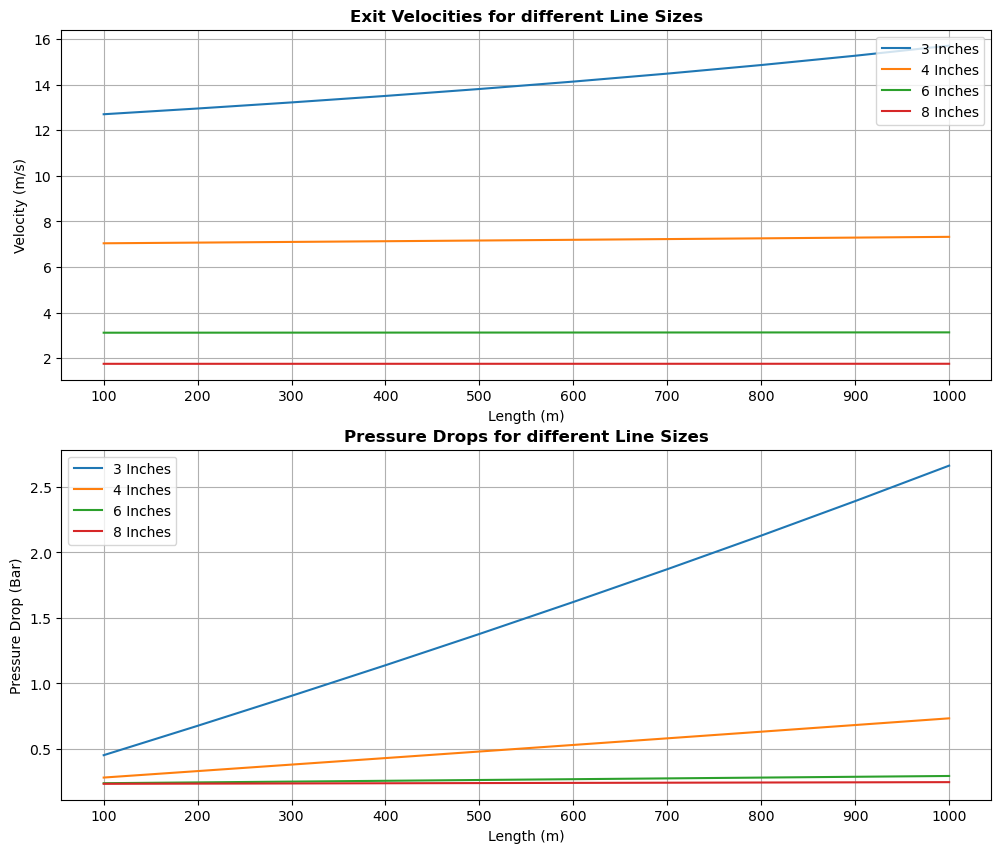

In [18]:
start,stop,step = 100,1100,100

T1,P1 = 25, 12 # Celcuis and bar
Q = 2300 # stdm3/hr
components_dict = {'methane':0.5,
    'ethane':0.25, 'propane':0.125, 'isobutane':0.0625, 'n-butane':0.0625}
L = range(100,1100,100) # meters
D_list = [3,4,6,8]
velocity = {}
pressure_drop = {}
for j in D_list:
    velocity[j] = []
    pressure_drop[j] = []
    for i in L:
        D = j * 0.0254

        df_result = gas_pressure_drop(Q,T1,P1,None,i,D,components_dict,case = "estimate downstream pressure")
        velocity[j].append(df_result.loc['Out velocity (m/s)','General Gas'])
        pressure_drop[j].append(df_result.loc['Dp every 100 m','General Gas']*i*0.980665/100) # Convert from kg/cm2 to Bar

fig,axs = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(12)
length_to_inspect = 800

for k,v in velocity.items():
    axs[0].plot(L,v,label=str(k)+" Inches")
    axs[0].set_xticks(L)
    axs[0].set_xticklabels(L)
    axs[0].set_xlabel("Length (m)")
    axs[0].set_ylabel("Velocity (m/s)")
    axs[0].grid(True)
    axs[0].legend()
    axs[0].title.set_text('Exit Velocities for different Line Sizes')
    axs[0].title.set_weight('bold')
for k,v in pressure_drop.items():
    axs[1].plot(L,v,label=str(k)+" Inches")
    axs[1].set_xticks(L)
    axs[1].set_xticklabels(L)
    axs[1].set_xlabel("Length (m)")
    axs[1].set_ylabel("Pressure Drop (Bar)")
    axs[1].title.set_text('Pressure Drops for different Line Sizes')
    axs[1].title.set_weight('bold')
    axs[1].grid(True)
    axs[1].legend()
plt.show()  


In [19]:
pd.DataFrame.from_dict(pressure_drop)

,3,4,6,8
0,0.451872,0.281031,0.237968,0.233274
1,0.676165,0.330413,0.244083,0.234691
2,0.904994,0.380005,0.250200,0.236108
3,1.138647,0.429809,0.256321,0.237526
4,1.377442,0.479829,0.262445,0.238944
5,1.621734,0.530067,0.268573,0.240361
6,1.871923,0.580527,0.274703,0.241779
7,2.128455,0.631210,0.280837,0.243197
8,2.391840,0.682121,0.286974,0.244616
9,2.662659,0.733262,0.293114,0.246034


In [20]:
pd.DataFrame.from_dict(velocity)

,3,4,6,8
0,12.701100,7.040142,3.117488,1.752887
1,12.952860,7.069955,3.119111,1.753098
2,13.220210,7.100150,3.120736,1.753310
3,13.504828,7.130736,3.122364,1.753521
4,13.808657,7.161719,3.123994,1.753733
5,14.133962,7.193111,3.125627,1.753944
6,14.483396,7.224919,3.127262,1.754156
7,14.860098,7.257152,3.128900,1.754368
8,15.267811,7.289821,3.130541,1.754579
9,15.711035,7.322935,3.132184,1.754791


Inspecting Length and Diameter effects on Pressure Drop and Line Velocity for Liquids

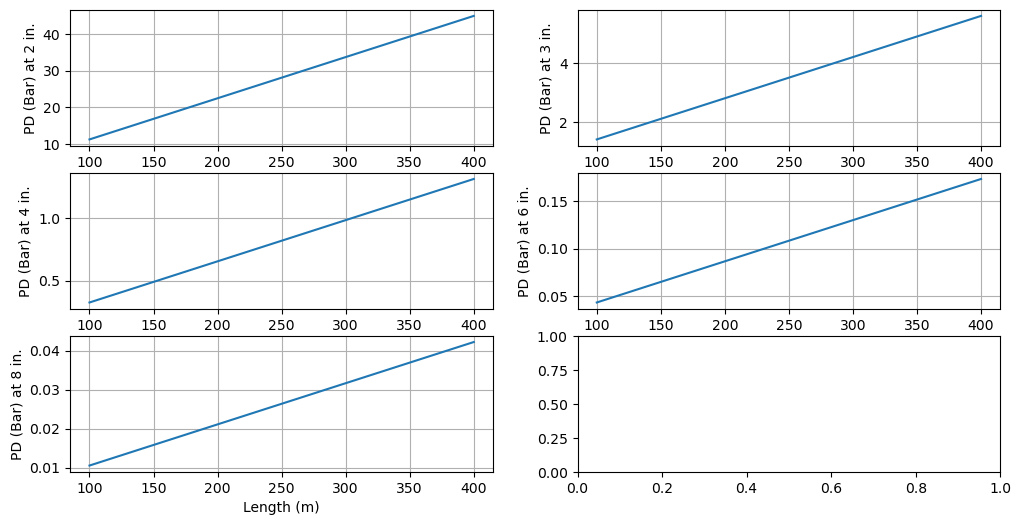

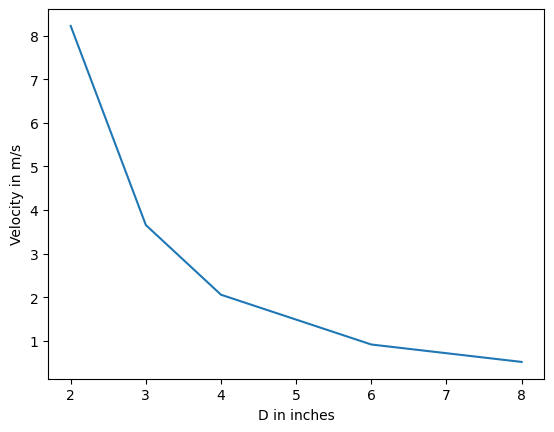

In [21]:
L = range(100,500,100) # meters
D = [2,3,4,6,8]
velocity = []
velocity_dict = {}
pressure_drop_dict = {}
for j in range(len(D)):
    pressure_drop = []
    for i in L:
        fitting = ['Pipe Segment']
        count = [1]
        length = [i]
        Dia = D[j] # Inches
        Q = 60 # m3/hr
        components_dict = {'water':1}
        fittings_dataframe,total_pressure_loss = liquid_pressure_drop(Q,Dia,fitting,count,length,components_dict)
        
        pressure_drop.append(total_pressure_loss)
        velocity_dict[j] = fittings_dataframe.loc['Pipe Segment_0','Velocity']
    pressure_drop_dict[j]=pressure_drop

fig,axs = plt.subplots(int(np.ceil(len(D)/2)),2)
fig.set_figheight(6)
fig.set_figwidth(12)
for i in range(len(D)):
    
    axs[int(round(i//2)),i%2].plot(list(L),list(pressure_drop_dict[i]))
    axs[int(round(i//2)),i%2].grid()
    axs[int(round(i//2)),i%2].set_xlabel("Length (m)")
    axs[int(round(i//2)),i%2].set_ylabel("PD (Bar) at {} in.".format(D[i]))
plt.figure()
plt.plot(D,velocity_dict.values())
plt.xlabel('D in inches')
plt.ylabel('Velocity in m/s')
plt.show()  

**Gas Solver** <br>

We'll Explore the possibility of coding a line sizing solver for gases. Given the required criteria: Pressure drop or velocity..etc., Could we estimate the gas Flow rate?

In [22]:
from scipy.optimize import minimize

def gas_solver(vars_D,L,T1,P1,P2,Q,components_dict,case_solver_dict,case,output_required=False ):
    """
    Solves for gas flow parameters such as velocity, pressure drop, or flow rate based on specified conditions.

    Parameters:
    vars_D (float): Diameter of the pipeline variable [inch].
    L (float): Length of the pipeline [m].
    T1 (float): Initial temperature of the gas [°C].
    P1 (float): Upstream pressure of the gas [kg/cm²].
    P2 (float): Downstream pressure of the gas [kg/cm²].
    Q (float): Standard volumetric flow rate of gas [Std_m³/hr].
    components_dict (dict): Dictionary containing gas components and their mole fractions.
    case_solver_dict (dict): Dictionary containing the type of case to solve and its corresponding value.
    case (str): Type of calculation to perform:
                - 'velocity': Solve for velocity to match a specified value.
                - 'pressure drop': Solve for pressure drop to match a specified value.
                - 'estimate downstream pressure': Estimate the downstream pressure.
                - 'estimate upstream pressure': Estimate the upstream pressure.
                - 'estimate quantity': Estimate the standard volumetric flow rate.
    output_required (bool, optional): Flag indicating if full output is required. Defaults to False.

    Returns:
    Depending on the case and output_required flag:
    - float: Absolute difference between calculated and specified value (for 'velocity' or 'pressure drop' cases).
    - list: List of parameters including Diameter [mm], Length [m], Initial Temperature [°C],
            Upstream Pressure [kg/cm²], Downstream Pressure [kg/cm²], Standard Volumetric Flow Rate [Std_m³/hr],
            Velocity [m/s] (for output_required=True).

    Notes:
    - Converts diameter from inches to meters internally.
    - Calculates gas flow parameters using the specified gas pressure drop function.
    - Handles different cases such as solving for velocity, pressure drop, or estimating pressures/flow rate.
    """
    D = float(vars_D)*0.0254
    df_result = gas_pressure_drop(Q,T1,P1,P2,L,D,components_dict,case)
    velocity = df_result.loc['Out velocity (m/s)','General Gas']
    pressure_drop = df_result.loc['Dp every 100 m','General Gas']*i*0.980665/100 # Convert from kg/cm2 to Bar

    if case_solver_dict['case'] == 'velocity' and output_required == False:
        return abs(velocity - case_solver_dict['value'])
    elif case_solver_dict['case'] == 'pressure drop'and output_required == False:
        return abs(pressure_drop - case_solver_dict['value'] )
    
    if output_required == True:
        if case ==  "estimate downstream pressure":
            P2 = df_result.loc['P2(Kg/cm2)','General Gas']
        elif case == "estimate upstream pressure": 
            P1 = df_result.loc['P1 (Kg/cm2)','General Gas'] 
        elif case == "estimate quantity":
            Q = df_result.loc['flow_rate (Std_m3/hr)','General Gas']      
        return [D*25.4,L,T1,P1,P2,Q,velocity]
L = 2000 # meters
D = 4 * 0.0254 # Convert In. to m
T1,P1 = 25, 12 # Celcuis and bar
Q = 2300 # stdm3/hr
P2 = 10.5
components_dict = {'methane':0.5,
    'ethane':0.25, 'propane':0.125, 'isobutane':0.0625, 'n-butane':0.0625}
case = "estimate quantity"
if case ==  "estimate downstream pressure":
    P2 = None
elif case == "estimate upstream pressure": 
    P1 = None 
elif case == "estimate quantity":
    Q = None
case_solver_dict = {'case':'velocity','value':8}
# con1= {'type':'ineq', 'fun': constraint_VP2_1,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
# con2 = {'type':'ineq', 'fun': constraint_VP2_2,'args':(inlet_divertor,mist_eliminator,P,V_H,V_S,Qv,Ql,rho_gas,rho_oil,gas_mass_fraction)}
# cons=[con1,con2]
initial_guess = [4]
bounds = [(2,20)]
result =minimize(gas_solver,args=(L,T1,P1,P2,Q,components_dict,case_solver_dict,case) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001) #, constraints= cons)
result_list = gas_solver(result.x,L,T1,P1,P2,Q,components_dict,case_solver_dict,case,output_required=True )

for i,j in enumerate(['Diameter in inches','Length in m','Flow Temperature','Inlet Pressure in Bar','Outlet Pressure in Bar','Flow in Nm3/hr','Velocity in m/s']):
    print('{} is {:0.2f}'.format(j,result_list[i]))

Diameter in inches is 2.02
Length in m is 2000.00
Flow Temperature is 25.00
Inlet Pressure in Bar is 12.00
Outlet Pressure in Bar is 10.50
Flow in Nm3/hr is 1401.64
Velocity in m/s is 8.00


**Liquid Solver** <br>

We'll Explore the possibility of coding a line sizing solver for Liquids. Given the required criteria: Pressure drop or velocity, Could we Find a proper Line Diameter?

In [23]:
def nearest_size_in(D):
    """Returns the nearest API standard size in inches for a given diameter.

    Parameters:
        D (float): The diameter of the vessel in feet.
        convert_from_ft_to_in (bool, optional): Specifies whether the input diameter is in feet.
                                                If True, the input diameter is converted to inches. Default is True.
    Returns:
        int: The nearest API standard size in inches.
    """

    API_STD_Sizes = [2,3,4,6,8,10,12,14,16,18,20,24]
    larger_D = [num for num in API_STD_Sizes if num > D]
    if larger_D:
        D_selected = min(larger_D)
        index_D = API_STD_Sizes.index(D_selected)
        suitable_size = API_STD_Sizes[index_D]
        return suitable_size 
    else:
        return int(D)
def liquid_solver(vars_D,Q,fitting,count,length,case_solver_dict,output_required=False ):
    """
    Solves for liquid flow parameters such as velocity or pressure drop based on specified conditions.

    Parameters:
    vars_D (float): Diameter of the pipeline [inches].
    Q (float): Volumetric flow rate of liquid [m³/h].
    fitting (list): List of fittings or segments in the pipeline.
    count (list): List of counts corresponding to each fitting or segment.
    length (list): List of lengths corresponding to each fitting or segment [m]. 
    case_solver_dict (dict): Dictionary containing the type of case to solve and its corresponding value.
    output_required (bool, optional): Flag indicating if full output is required. Defaults to False.

    Returns:
    Depending on the case and output_required flag:
    - float: Absolute difference between calculated and specified value (for 'velocity' or 'pressure drop' cases). (When minimizing)
    - tuple: Tuple containing Diameter [m], pressure drop [Bar], and velocity [m/s] (for output_required=True). (When obtaining your Minimized solution output)

    Notes:
    - Calculates required Diameter using the specified liquid pressure drop function.
    - Handles different cases such as solving for velocity or pressure drop to match a specified value.
    - Make sure your target pipe segment is your FIRST pipe segment!
    """
    D = float(vars_D)
    fittings_dataframe,total_pressure_loss = liquid_pressure_drop(Q,D,fitting,count,length,components_dict)
    pressure_drop = total_pressure_loss
    mask = fittings_dataframe.index.str.contains('Pipe Segment')
    velocity = fittings_dataframe.loc[mask,'Velocity'][0]
    if case_solver_dict['case'] == 'velocity' and output_required == False:
        return abs(velocity - case_solver_dict['value'])
    elif case_solver_dict['case'] == 'pressure drop'and output_required == False:
        return abs(pressure_drop - case_solver_dict['value'] )
    
    if output_required == True:
        return D,pressure_drop,velocity

fitting = ['Pipe Segment']
count = [2]
length = [10]
Q = 60 # m3/hr
components_dict = {'water':1}
case_solver_dict = {'case':'velocity','value':5}
# def constraint_forD(x):
#     return x%2 
# con1 = {'type':'eq', 'fun': constraint_forD}
# cons=[con1]
initial_guess = [4]
bounds = [(2,20)]
result =minimize(liquid_solver,args=(Q,fitting,count,length,case_solver_dict) ,x0=initial_guess, bounds=bounds,method='SLSQP', tol = 0.00001 )#, constraints= cons)
result_list = liquid_solver(result.x,Q,fitting,count,length,case_solver_dict,output_required=True )

for i,j in enumerate(['Diameter in inches','Pressure drop in bar','Velocity in m/s']):
    print('{} is {:0.2f}'.format(j,result_list[i]))

Diameter in inches is 2.56
Pressure drop in bar is 0.62
Velocity in m/s is 5.00
